# Hillary vs Clinton Tweets Dataset Analysis
## Sentimental, Topical and Correlation analysis

In this project, we will explore tweets done between 12/6/2016 and 12/9/2016 in an effort to understand "What happened?!". We will go over sentimental analysis of the tweets, the kind of topics discussed and the correlation analysis with result of the election.

## The questions we are exploring:

- What is the sentiment towards the candidates?
- Where are the candidates more popular?
- Which topics are the candidates and their supporters talking about?
- How big is the divide between the supporters?

## Data preprocessing
Here we preprocess the data to for easier analysis.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as scs
import ijson
import json
import random
from tqdm import tqdm_notebook as tqdm
from wordcloud import WordCloud
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## We load the data from our dataset

This dataset seems quite large and its not setup as an actual Json object. We will read the json objects line by line and then only select the information we are interested in.

We will also mark mentions of either hillary, trump or both on the tweet for easier analysis.

In [3]:
from dateutil import parser

filename = "geotagged_tweets_20160812-0912.json"
with open(filename) as f:
    
    texts = []
    created_at = []
    source = []
    likes = []
    retweet_count = []
    country = []
    place_name = []
    place_type = []
    candidate = []
    
    tweet_id_to_index = {}
    
    def parse_obj(json_obj):
        texts.append(json_obj["text"])
        created_at.append(parser.parse(json_obj["created_at"]).date())
        source.append(json_obj["source"])
        likes.append(int(json_obj["favorite_count"]))
        retweet_count.append(int(json_obj["retweet_count"]))
        if "place" in json_obj and json_obj["place"] !=None:
            country.append((json_obj["place"]["country"] if "country" in json_obj["place"] and 
                                 json_obj["place"]["country"] != None else "None"))
            place_name.append(json_obj["place"]["name"] if "name" in json_obj["place"] and 
                                   json_obj["place"]["name"] != None else "None")
            place_type.append(json_obj["place"]["place_type"] if "place_type" in json_obj["place"] and 
                                   json_obj["place"]["place_type"] != None else "None")
        else:
            country.append("None")
            place_name.append("None")
            place_type.append("None")
        mentions = "niether"
        for mention in json_obj["entities"]["user_mentions"]:
            if mention['screen_name'] == 'realDonaldTrump':
                if mentions == "niether":
                    mentions = "trump"
                else:
                    mentions = "both"
            elif mention['screen_name'] == "HillaryClinton":
                if mentions == "niether":
                    mentions = "hillary"
                else:
                    mentions = "both"
        candidate.append(mentions)
    
    i=0
    for line in tqdm(f):
        try:
            json_obj = json.loads(line)
            if json_obj["id"] in tweet_id_to_index:
                continue
            else:
                tweet_id_to_index[json_obj["id"]] = i
                
            parse_obj(json_obj)
            i+=1
            if "quoted_status" in json_obj:
                quote = json_obj["quoted_status"]
                if quote["id"] in tweet_id_to_index:
                    continue
                else:
                    tweet_id_to_index[json_obj["id"]] = i
                parse_obj(quote)
                i+=1
            
        except:
            print(json_obj)

    tweets_df = pd.DataFrame(np.array(texts), columns=['text'])
    tweets_df['created_at'] = np.array(created_at)
    tweets_df['source'] = np.array(source)
    tweets_df['likes'] = np.array(likes)
    tweets_df['retweet_count'] = np.array(retweet_count)
    tweets_df['country'] = np.array(country)
    tweets_df['place_name'] = np.array(place_name)
    tweets_df['place_type'] = np.array(place_type)
    tweets_df['candidate'] = np.array(candidate)
    tweets_df = tweets_df.iloc[1:]

Widget Javascript not detected.  It may not be installed or enabled properly.


In [41]:
tweets_df.to_pickle("tweets_pickle") 
tweets_df.describe()

# Here we plot the likes and retweets over time

This is to see how popular certain tweets became about the candidated. This is a better indication than number of retweets to filter out noise from unrelated tweets.

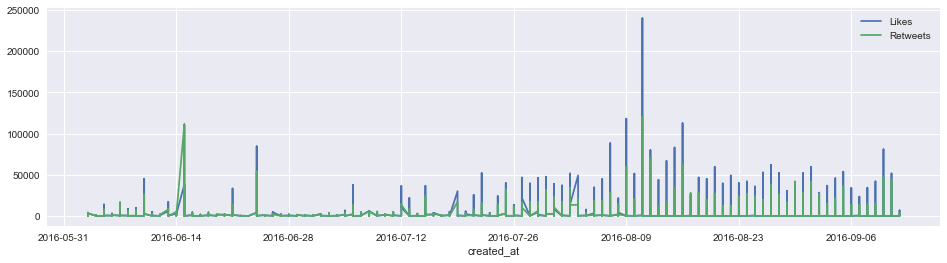

In [4]:
relevant_tweets = tweets_df.loc[tweets_df['created_at'] > datetime.date(2016, 6, 2)]
fav = pd.Series(data=relevant_tweets['likes'].values, 
                index=relevant_tweets['created_at'])
ret = pd.Series(data=relevant_tweets['retweet_count'].values, index=relevant_tweets['created_at'])

fav.plot(figsize=(16,4), label="Likes", legend=True)
ret.plot(figsize=(16,4), label="Retweets", legend=True);

The tweets naturally start picking up in activity after June 2016. Before that there spikes of activity relating the candidates. It will be interesting to see retweets by candidate.

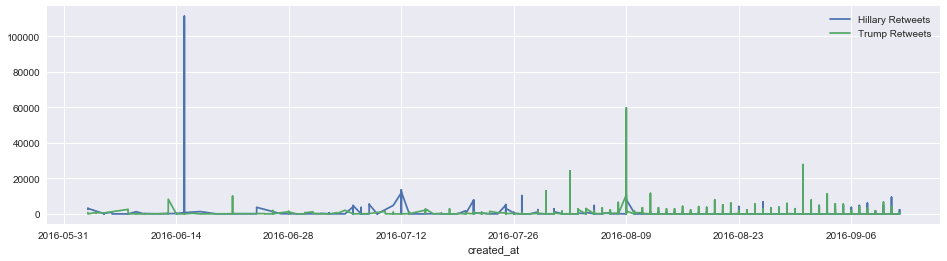

In [5]:
hillary = pd.Series(data=relevant_tweets.loc[relevant_tweets['candidate'] == "hillary"]['retweet_count'].values, 
                index=relevant_tweets.loc[relevant_tweets['candidate'] == "hillary"]['created_at'])

trump = pd.Series(data=relevant_tweets.loc[relevant_tweets['candidate'] == "trump"]['retweet_count'].values, 
                index=relevant_tweets.loc[relevant_tweets['candidate'] == "trump"]['created_at'])

hillary.plot(figsize=(16,4), label="Hillary Retweets", legend=True);
trump.plot(figsize=(16,4), label="Trump Retweets", legend=True);

So there are 2 spikes of activity regarding the candidates. One is at 15/6/2016 towards Hillary, which corresponds with the email scandal. The second spike is at 9/8/2016 when Trump was elected president.

# Sentiment Analysis

Here we will begin sentiment analysis on the tweets. We will do this using textblob which is a NL libraby for python. First we need to clean the text before producing the sentiment score.

We will attempt to answer the question:
- What is the sentiment towards the candidates?

In [6]:
from textblob import TextBlob
import re

def clean_tweet(tweet):
    # Removes links and special characters
    return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())

def analize_sentiment(tweet):
    # Function to analyze sentiment
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return "positive"
    elif analysis.sentiment.polarity == 0:
        return "neutral"
    else:
        return "negative"

# We create a column with the result of the analysis:
tweets_df['sentiment'] = np.array([ analize_sentiment(tweet) for tweet in tweets_df.loc[:, "text"] ])
tweets_df.to_pickle("tweets_pickle")

Now that we have created the sentiments column, we get the count of the tweets by sentiment of the data we have.

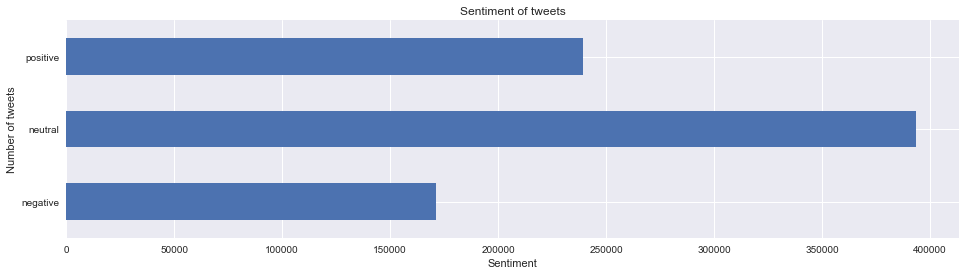

In [74]:
tweets_sentiment = (tweets_df.groupby(['sentiment'])).count().unstack('text')['text']
tweets_sentiment.plot.barh(figsize=(16,4), title = 'Sentiment of tweets', stacked=True)
plt.xlabel('Sentiment')
plt.ylabel('Number of tweets')
plt.show()

Here we see that the majority of tweets are neutral, likely from news outlets. Then we have more positive tweets than negative tweets over all.

### Tweets Sentiment by candidate

Here we plot the sentiment by candidate mention.

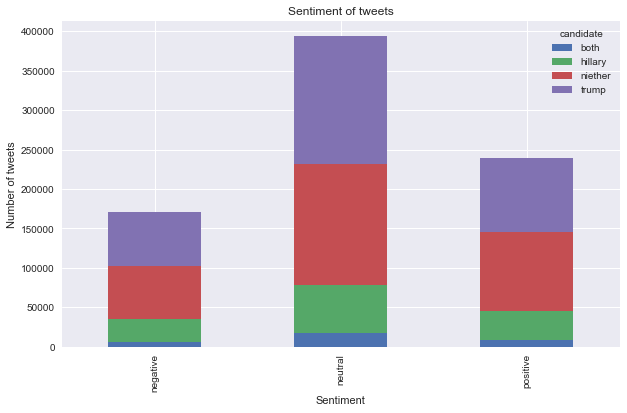

In [75]:
tweets_sentiment = (tweets_df.groupby(['sentiment'])).count().unstack('candidate')['text']
class_ct = pd.crosstab(tweets_df.sentiment, tweets_df.candidate, margins=True)
class_ct = class_ct.drop('All', 1)
class_ct[:3].plot(title = 'Sentiment of tweets', kind='bar', stacked=True)
plt.xlabel('Sentiment')
plt.ylabel('Number of tweets')
plt.show()

From the above graph, it is hard to drive any knowledge regarding the candidates since tweets mentioning both are overwhelming in number. However, it seems that neutral tweets are much more than positive or negative tweets. 

For the next step we exclude tweets that mention both or neither.

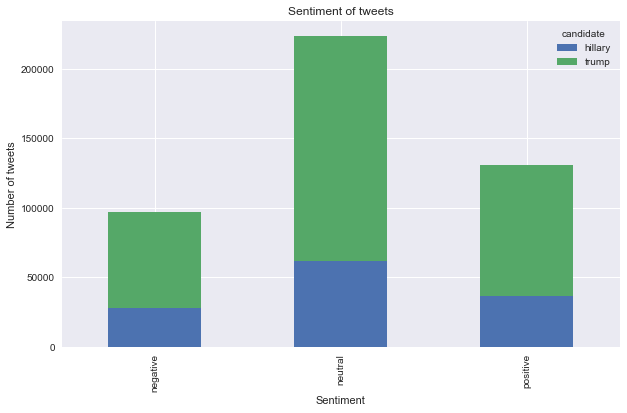

In [76]:
class_ct = class_ct.drop('both', 1)
class_ct = class_ct.drop('niether', 1)
class_ct[:3].plot(title = 'Sentiment of tweets', kind='bar', stacked=True)
plt.xlabel('Sentiment')
plt.ylabel('Number of tweets')
plt.show()

In a surprising turn of events. It seems that Trump has more positive tweets than negative, while Hillary is getting more negative tweets than positive.

In [77]:
class_ct[:3]

candidate,hillary,trump
sentiment,,
negative,28180,69012
neutral,62005,161613
positive,36271,94537


# Negative tweets

Here we will explore a bit more the text of the negative tweets directed at both candidates. We want to see the most used words targeted at both candidates.

In [78]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_colwidth', -1)
tweets_df.loc[tweets_df['sentiment'] == 'negative'][['text', 'candidate']].head()

,text,candidate
10,"@HillaryClinton you ARE the co-founder of ISIS, you crooked, evil, lying, witch. How can you live with yourself?",hillary
13,"@realDonaldTrump @elsolarverde What issues? Your idiot claim that she ""founded"" ISIS? Trump will go to Hell for lying &amp; stealing. Shame!",trump
18,"GOP pleading w Trump ""Just control your behavior for a few weeks, then do what you want for 4 years"" - Terrifying! #NeverTrump #Crazy",niether
22,@sherrilee7 @seanhannity @HillaryClinton #Hannity what do you think of being disbarred? You are ignorant Mr. Hamburg or just dishonest?,hillary
23,@realDonaldTrump stop worrying about the MSM lies. Focus on econ&amp;imm&amp;dfns. Ur spprtrs already know she's scum &amp; MSM is in the tank for her.,trump


## Hillary Negative Tweets

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hassan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


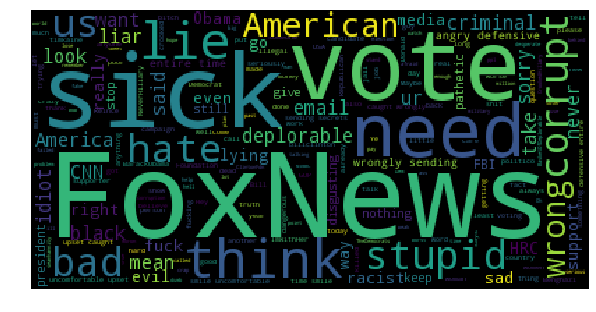

In [107]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
text = ' '.join(tweets_df.loc[(tweets_df['sentiment'] == 'negative') & (tweets_df['candidate'] == 'hillary')]['text'])
REMOVE_LIST = ["https", "co", "Trump", "Hillary", "realdonaldtrump", "hillaryclinton", "amp", "one", "going", "say", 
               "Know", "clinton", "potus", "see", "make", "people"]
REMOVE_LIST.extend(stopwords.words('english'))

remove = '|'.join(REMOVE_LIST)
regex = re.compile(r'\b('+remove+r')\b', flags=re.IGNORECASE)
text = regex.sub("", text)
                
                
wordcloud = WordCloud().generate(text)
# Generate plot
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Seems that the most negative words are Sick, corrupt, mean, lie, criminal, evil and lie. From this we see that most of the negative words were themed around the sentiment that she lied about her private email server.

It is very interesting how FoxNews is trending in the word cloud. This could hint towards the fact that Fox News was mostly supporting Trump over Hillary.

## Trump Negative Tweets

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hassan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


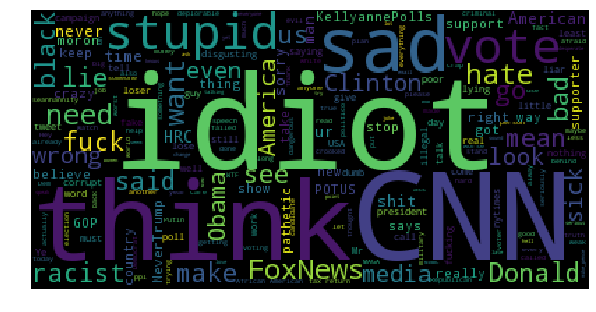

In [105]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
text = ' '.join(tweets_df.loc[(tweets_df['sentiment'] == 'negative') & (tweets_df['candidate'] == 'trump')]['text'])
REMOVE_LIST = ["https", "co", "Trump", "Hillary", "realdonaldtrump", "hillaryclinton", "amp", "one", "going", 
               "say", "Know", "people"]
REMOVE_LIST.extend(stopwords.words('english'))

remove = '|'.join(REMOVE_LIST)
regex = re.compile(r'\b('+remove+r')\b', flags=re.IGNORECASE)
text = regex.sub("", text)
                
                
wordcloud = WordCloud().generate(text)
# Generate plot
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Here the biggest word in the word cloud is Idiot. Followed by CNN, think, sad, stupid, mean, racist, lie and various profanities.

It is interesting to see that CNN is trending here. That supports the notion that CNN supported Hillary over trump.

## Negative Words

Looking at both word clouds for both candidates, it seems that Trump's negative tweets while they were less than hillary's, they were much more profane and diverse. However Hillary was much more focused on how she lied about her private servers.

# Sentiment by location

Here we will look at the distribution of sentiment by location to see if there is a pattern invloved.

In [267]:
from city_to_state import city_to_state_dict

def get_city_state(row):
    if row['place_type']=='city' or row['place_type']=='admin':
        if row['place_name'] in city_to_state_dict:
            return city_to_state_dict[row['place_name']]
        else:
            return None
    """
    elif row['place_type']=='admin':
        if row['place_name'] == 'Austin TX':
            return 'Texas'
        return row['place_name']
        """
    return None

tweets_df['state'] = tweets_df.apply (lambda row: get_city_state (row),axis=1)

Here we populate the state the tweets come from for those we know.

## Hillary Sentiment by state

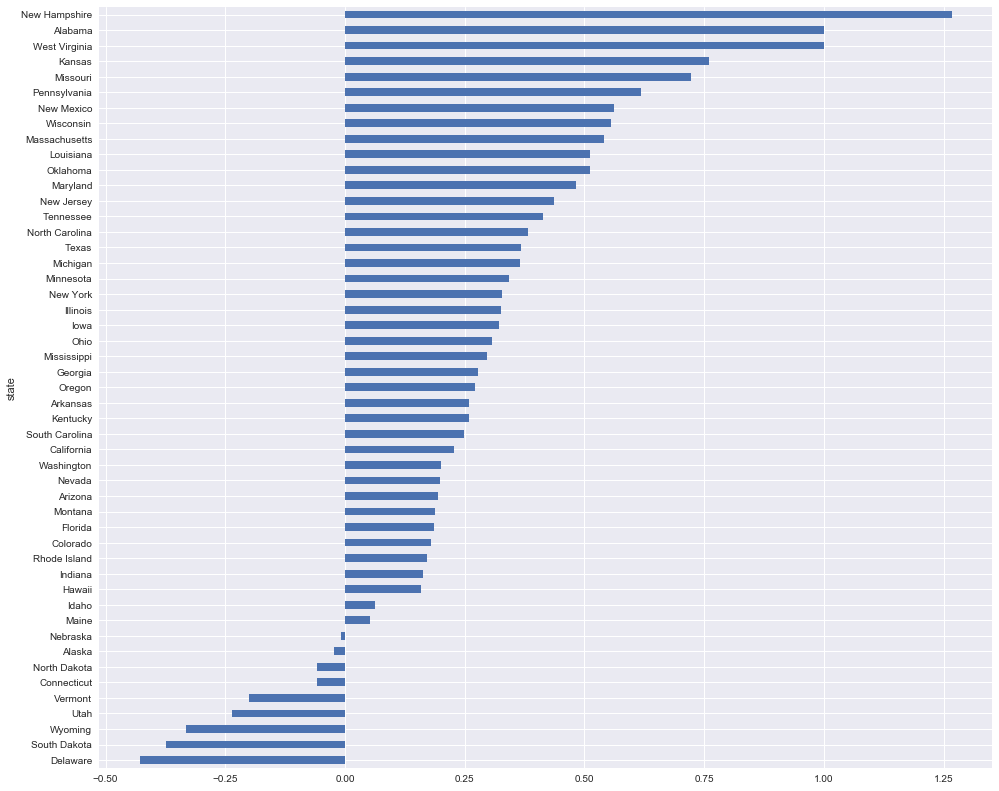

In [270]:
tweet_count = tweets_df.loc[(tweets_df['sentiment'] != 'neutral') & 
            (tweets_df['candidate'] == 'hillary') & 
              (tweets_df['country'] == 'United States') &
              (tweets_df['state'] != None)].groupby(['state', 'sentiment'])['text'].count()
#t = tweet_count.apply(lambda x: x['positive'] / x['negative'])
tweet_count = tweet_count.unstack().apply(lambda x: (x['positive'] / x['negative'])-1,axis=1)
tweet_count = tweet_count.dropna()
tweet_count.sort_values().plot.barh(figsize=(16,14))

In [269]:
from bokeh.sampledata import us_states, us_counties, unemployment
from bokeh.plotting import *
from states_ab import states_ab

def blend(color, alpha, base=[255,255,255]):
    '''
    color should be a 3-element iterable,  elements in [0,255]
    alpha should be a float in [0,1]
    base should be a 3-element iterable, elements in [0,255] (defaults to white)
    '''
    out = [int(round((alpha * color[i]) + ((1 - alpha) * base[i]))) for i in range(3)]

    return '#'+''.join(["%02x" % e for e in out])

us_states_dict = us_states.data.copy()

# separate latitude and longitude points for the borders
#   of the states.
state_xs = [us_states_dict[code]["lons"] for code in us_states_dict]
state_ys = [us_states_dict[code]["lats"] for code in us_states_dict]

state_colors = []

us_states = us_states.data.copy()

i = 0
for state_id in us_states_dict:
    try:
        if state_id in states_ab:
            rate = tweet_count[states_ab[state_id]]
        else:
            rate = 0
        idx = min(int(rate), 5)
        if rate > 0:
            state_colors.append(blend([0,255,0],rate))
        else:
            state_colors.append(blend([255,0,0],-1*rate))
    except KeyError:
        state_colors.append("black")
    i += 1

# init figure
p = figure(title="Plotting Negative sentiment toward Hillary by State", 
           toolbar_location="left", plot_width=1100, plot_height=700, x_range=(-130, -60), y_range=(25, 50))

# Draw state lines
p.patches(state_xs, state_ys, fill_color=state_colors, fill_alpha=1,
    line_color="#884444", line_width=1.5)

# output to static HTML file
output_file("hillary_map.html")

# show results
show(p)

![Image of Yaktocat](hillarys_map.png)

There seem to be some states that were very negative towards Hillary than others. Overly active in negative tweets towards Hillary.

## Trump Sentiment by state

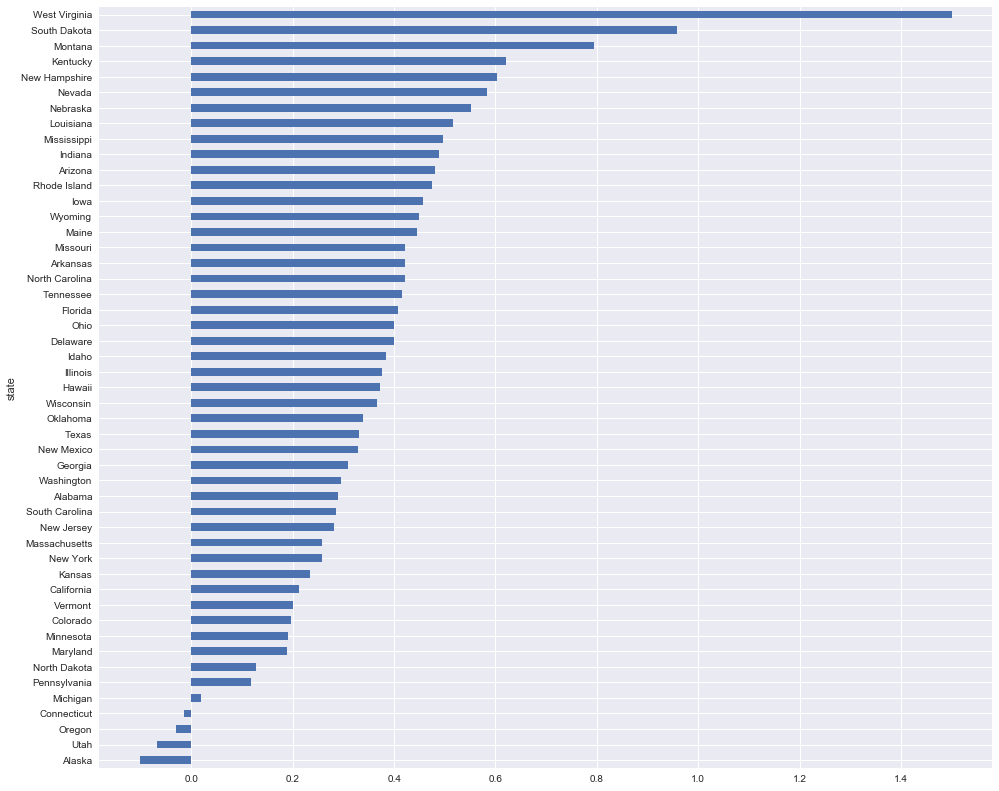

In [271]:
tweet_count = tweets_df.loc[(tweets_df['sentiment'] != 'neutral') & 
            (tweets_df['candidate'] == 'trump') & 
              (tweets_df['country'] == 'United States') &
              (tweets_df['state'] != None)].groupby(['state', 'sentiment'])['text'].count()
#t = tweet_count.apply(lambda x: x['positive'] / x['negative'])
tweet_count = tweet_count.unstack().apply(lambda x: (x['positive'] / x['negative'])-1,axis=1)
tweet_count = tweet_count.dropna()
tweet_count.sort_values().plot.barh(figsize=(16,14))

In [272]:
from bokeh.sampledata import us_states, us_counties, unemployment
from bokeh.plotting import *
from states_ab import states_ab

def blend(color, alpha, base=[255,255,255]):
    '''
    color should be a 3-element iterable,  elements in [0,255]
    alpha should be a float in [0,1]
    base should be a 3-element iterable, elements in [0,255] (defaults to white)
    '''
    out = [int(round((alpha * color[i]) + ((1 - alpha) * base[i]))) for i in range(3)]

    return '#'+''.join(["%02x" % e for e in out])

us_states_dict = us_states.data.copy()

# separate latitude and longitude points for the borders
#   of the states.
state_xs = [us_states_dict[code]["lons"] for code in us_states_dict]
state_ys = [us_states_dict[code]["lats"] for code in us_states_dict]

state_colors = []

us_states = us_states.data.copy()

i = 0
for state_id in us_states_dict:
    try:
        if state_id in states_ab:
            rate = tweet_count[states_ab[state_id]]
        else:
            rate = 0
        idx = min(int(rate), 5)
        if rate > 0:
            state_colors.append(blend([0,255,0],rate))
        else:
            state_colors.append(blend([255,0,0],-1*rate))
    except KeyError:
        state_colors.append("black")
    i += 1

# init figure
p = figure(title="Plotting Negative sentiment toward Hillary by State", 
           toolbar_location="left", plot_width=1100, plot_height=700, x_range=(-130, -60), y_range=(25, 50))

# Draw state lines
p.patches(state_xs, state_ys, fill_color=state_colors, fill_alpha=1,
    line_color="#884444", line_width=1.5)

# output to static HTML file
output_file("hillary_map.html")

# show results
show(p)

![Image of Yaktocat](trump_map.png)

Interestingly, there does not seem to be any state that has too much negativity over other states towards Trump. Mostly it is balanced. Very different to how Hillary's results. This also is very different than the fact that Hillary won the popular vote.

It is also very interesting how west virigina is very positive towards Trump. This corresponds to how west viriginia overwhelmingly supported trump over Hillary in the votes.

## Sentiment over time

Here we look at the sentiment toward the candidates over time.

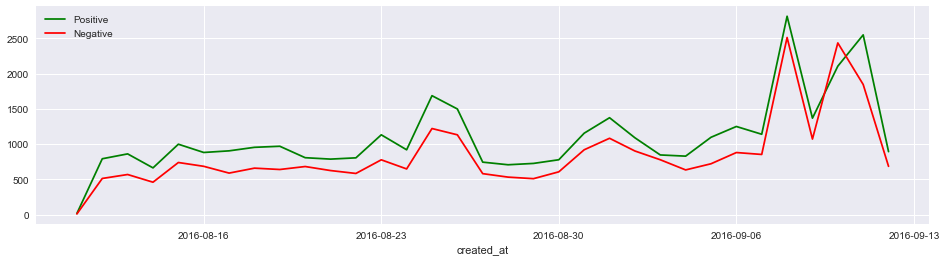

In [25]:
relevant_tweets = tweets_df.loc[(tweets_df['created_at'] > datetime.date(2016, 8, 10)) & 
                                (tweets_df['candidate']=="hillary")]

positive_tweets = (relevant_tweets.loc[relevant_tweets['sentiment']=='positive']
                   .groupby(['created_at'])).count().unstack('sentiment')

positive_tweets['sentiment'].plot(figsize=(16,4), label="Positive", legend=True, color="green")

negative_tweets = (relevant_tweets.loc[relevant_tweets['sentiment']=='negative']
                   .groupby(['created_at'])).count().unstack('sentiment')

negative_tweets['sentiment'].plot(figsize=(16,4), label="Negative", legend=True, color="red")


Here we can see that Hillary had a mostly consistent coverage. At points, we can see that her positive to negative sentiment is nearly zero or more negative than positive near the end. This again contradicts the fact that she won the popular vote.

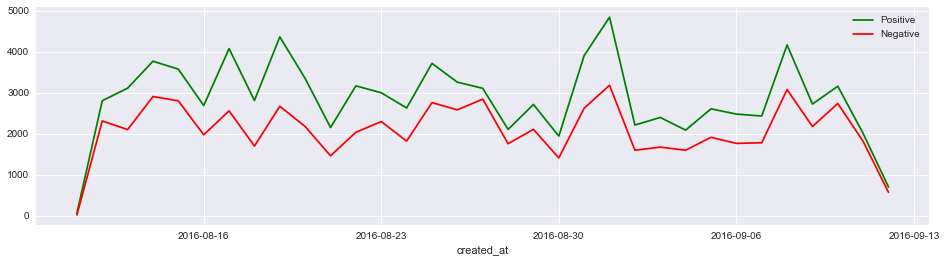

In [26]:
relevant_tweets = tweets_df.loc[(tweets_df['created_at'] > datetime.date(2016, 8, 10)) & 
                                (tweets_df['candidate']=="trump")]

positive_tweets = (relevant_tweets.loc[relevant_tweets['sentiment']=='positive']
                   .groupby(['created_at'])).count().unstack('sentiment')

positive_tweets['sentiment'].plot(figsize=(16,4), label="Positive", legend=True, color="green")

negative_tweets = (relevant_tweets.loc[relevant_tweets['sentiment']=='negative']
                   .groupby(['created_at'])).count().unstack('sentiment')

negative_tweets['sentiment'].plot(figsize=(16,4), label="Negative", legend=True, color="red")


Trump has been consistently getting more positive sentiment than negative. That again contradicts with the fact that he lost the popular vote.

# Conclusion

It was certainly an interesting race and produced interested data from twitter. While just from the sentiment analysis, Hillary appeared to be losing. However the sentiment seem to suggest that Hillary was losing the popular vote, in the end she did win the popular vote but lost the electoral vote.

This dataset is quite rich, there is so much more that can be done with it. Like hashtag usage analysis. Correlating the activity with actual news. Also user activity analysis to see if certain users were more active about their opinion than others.